# TEST DIFFERENT INTERPOLATION METHODS

Anlayse different interpolation methods, analyse and visualize the results. 

1. To test interpolation methods I mask 10% of timepoints and interpolated them using one of interpolation methods:
- LINEAR
- CUBIC
- QUADRATIC
- NEAREST
- PCHIP
- BSPLINE of degree 1
- BSPLINE of degree 2
- BSPLINE of degree 3

Each interpolation is performed 10 times with different 10% points masked each time

2. Then, I analyse the results using:

Transform data to 100% and using CLR to work on ratios and not counts.

- Mantel test between true and interpolated datapoins (Bray Curtis distance matrices)
- Bray Curtis distance between true and interpolated data
- RMSE for each timepoint
- RMSE for each features

Mantel test and BC will be also calculated between interpolated and previous or next day to verify how much the interpolation uses closest points 

3. Next, I plot lineplots between true and interpolated data (median counts per timestep)

In [1]:
from skbio.stats.composition import clr
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import skbio
from skbio.stats.distance import mantel
from skbio.diversity import alpha
from scipy import interpolate, stats
from scipy.spatial import distance
from scipy.interpolate import pchip_interpolate, BSpline, splev
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error

In [2]:
sns.set_style('whitegrid')

In [3]:
PATH = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction/'
FILE = 'female_assigned_sample_names.csv'

DF = pd.read_csv(PATH + FILE, index_col=[0])
DF.index  = DF.index.astype(int)
DF = DF + 1e-5
DF_SUM = DF.div(DF.sum(axis=1), axis=0)

# add pseudocount
DF = DF + 1e-2

# transform using clr 
CLR_DF = pd.DataFrame(clr(DF), columns=DF.columns)
CLR_DF.index = DF.index

### INTERPOLATE

In [4]:
#linear interpolation
def linear_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='linear')
    
    new_y = f(interpolated_nodes)
    
    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [5]:
'''def cubic_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='cubic')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated'''

"def cubic_interpolation(col, masked_df):\n    \n    df_interpolated = pd.DataFrame(index = masked_df.index)\n\n    tmp = masked_df[col]\n    base_nodes =  tmp.dropna().index #wezlowe\n    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy\n    \n    f = interpolate.interp1d(base_nodes,\n                             tmp.dropna().values,\n                             kind='cubic')\n    new_y = f(interpolated_nodes)\n\n    name = str(col)\n    df_interpolated.loc[base_nodes, name] = tmp.dropna().values\n    df_interpolated.loc[interpolated_nodes, name] = new_y\n    \n    return df_interpolated"

In [6]:
'''def quardatic_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='quadratic')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated'''

"def quardatic_interpolation(col, masked_df):\n    \n    df_interpolated = pd.DataFrame(index = masked_df.index)\n\n    tmp = masked_df[col]\n    base_nodes =  tmp.dropna().index #wezlowe\n    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy\n    \n    f = interpolate.interp1d(base_nodes,\n                             tmp.dropna().values,\n                             kind='quadratic')\n    new_y = f(interpolated_nodes)\n\n    name = str(col)\n    df_interpolated.loc[base_nodes, name] = tmp.dropna().values\n    df_interpolated.loc[interpolated_nodes, name] = new_y\n    \n    return df_interpolated"

In [5]:
def nearest_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='nearest')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [6]:
def pchip_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)
    
    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy

    y = pchip_interpolate(base_nodes,
                          tmp.dropna().values,
                          interpolated_nodes)
    
    
    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = y
    
    return df_interpolated

In [7]:
def bspline_interpolation(col, masked_df, degree=1):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = BSpline(base_nodes,tmp.dropna().values, degree)
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [8]:
def apply_interpolation(df, interpolation_function):
    
    INTERPOLATED_COLUMNS = []
    for col in df.columns:
        interpolated_col = interpolation_function(col, df)
        INTERPOLATED_COLUMNS.append(interpolated_col)
    INTERPOLATED_DF = pd.concat(INTERPOLATED_COLUMNS, axis=1)
    
    return INTERPOLATED_DF


def apply_bspline_interpolation(df, interpolation_function, degree=1):
    
    INTERPOLATED_COLUMNS = []
    for col in df.columns:
        interpolated_col = interpolation_function(col, df, degree)
        INTERPOLATED_COLUMNS.append(interpolated_col)
    INTERPOLATED_DF = pd.concat(INTERPOLATED_COLUMNS, axis=1)
    
    return INTERPOLATED_DF

In [9]:
def change_to_composition(data):
    
    df_prc = data.apply(lambda x: x.div(x.sum()), axis=1) + 1e-9
    df_clr = clr(df_prc)
    df_clr = pd.DataFrame(df_clr, columns = data.columns)
    df_clr.index = data.index
    
    return df_clr

In [10]:
def calculate_mantel_test(true_df, interpolated_df, metric):
    
    interpolated_df = change_to_composition(interpolated_df)
    true_df = change_to_composition(true_df)
        
    TRUE_DISTANCE_MATRIX = squareform(pdist(true_df, metric = metric))
    INTERPOLATED_DISTANCE_MATRIX = squareform(pdist(interpolated_df, metric = metric))

    corr = mantel(TRUE_DISTANCE_MATRIX, INTERPOLATED_DISTANCE_MATRIX)[0]
    
    return corr

def calculate_braycurtis(true_df, interpolated_df):
    
    interpolated_df = change_to_composition(interpolated_df)
    true_df = change_to_composition(true_df)
    
    BC = []
    for i in true_df.index.tolist():

        bc = distance.braycurtis(true_df.loc[i], interpolated_df.loc[i])
        BC.append(bc)

    MEAN_BC = np.mean(BC)
    
    return MEAN_BC

def calculate_rmse_timesteps(true_df, interpolated_df):
    
    RMSE = []
    for i in true_df.index.tolist():
        

        rmse = mean_squared_error(interpolated_df.iloc[i, :], true_df.iloc[i, :], squared=False)
        RMSE.append(rmse)
        
    MEAN_RMSE = np.mean(RMSE)
        
    return MEAN_RMSE


def calculate_rmse_features(true_df, interpolated_df):
    
    RMSE = []
    for i in range(len(true_df.columns)):

        rmse = mean_squared_error(interpolated_df.iloc[:, i], true_df.iloc[:, i], squared=False)
        RMSE.append(rmse)

    MEAN_RMSE = np.mean(RMSE)
    
    return MEAN_RMSE

In [11]:
def calculate_interpolation_similarity(true_data, interpolated_dfs, interpolation_names):
     
    
    MANTEL = []
    BC = []
    RMSE_TIMESTEP = []
    RMSE_FEATURE = []

    for interpolated_df in interpolated_dfs:
        
        mantel_rho = calculate_mantel_test(true_data, interpolated_df, 'braycurtis')
        bc_distance = calculate_braycurtis(true_data, interpolated_df)
        rmse_timestep = calculate_rmse_timesteps(true_data, interpolated_df)
        rmse_feature = calculate_rmse_features(true_data, interpolated_df)

        MANTEL.append(mantel_rho)
        BC.append(bc_distance)
        RMSE_TIMESTEP.append(rmse_timestep)
        RMSE_FEATURE.append(rmse_feature)

    MANTEL_DF = pd.DataFrame(list(zip(interpolation_names, MANTEL)), columns = ['INTERPOLATION', 'MANTEL_RHO'])
    BC_DF = pd.DataFrame(list(zip(interpolation_names, BC)), columns = ['INTERPOLATION', 'BC'])
    RMSE_TIMESTEP_DF = pd.DataFrame(list(zip(interpolation_names, RMSE_TIMESTEP)), columns = ['INTERPOLATION', 'RMSE_TIMESTEP'])
    RMSE_FEATURE_DF = pd.DataFrame(list(zip(interpolation_names, RMSE_FEATURE)), columns = ['INTERPOLATION', 'RMSE_FEATURE'])

    return MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF, RMSE_FEATURE_DF

In [12]:
def interpolation_experiment_true(data):
    
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    TRUE_DATA = data.loc[INDEX_TO_MASK].reset_index(drop=True)
    
    MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF = calculate_interpolation_similarity(TRUE_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF

In [13]:
def interpolation_experiment_previous(data):
        
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    PREVIOUS_INDEX = [i-1 for i in INDEX_TO_MASK]
    PREVIOUS_DATA = data.loc[PREVIOUS_INDEX].reset_index(drop=True)

    MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF = calculate_interpolation_similarity(PREVIOUS_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF

In [14]:
def interpolation_experiment_next(data):
    
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    NEXT_INDEX = [i-1 for i in INDEX_TO_MASK]
    NEXT_DATA = data.loc[NEXT_INDEX].reset_index(drop=True)

    MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF = calculate_interpolation_similarity(NEXT_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return MANTEL_DF, BC_DF, RMSE_TIMESTEP_DF,  RMSE_FEATURE_DF

In [15]:
def iterate_over_interpolation_results(df, experiment_function):
    
    ITERATION = []
    MANTEL = []
    BC = []
    RMSE_TIMESTEP = []
    RMSE_FEATURE = []

    for i in range(0, 10):
        mantel_df, bc_df, rmse_time, rmse_feature = experiment_function(df)
        mantel_df['iteration'] = i
        bc_df['iteration'] = i
        rmse_time['iteration'] = i
        rmse_feature['iteration'] = i
        

        MANTEL.append(mantel_df)
        BC.append(bc_df)
        RMSE_TIMESTEP.append(rmse_time)
        RMSE_FEATURE.append(rmse_feature)
        
    MANTEL = pd.concat(MANTEL)
    BC = pd.concat(BC)
    RMSE_TIMESTEP = pd.concat(RMSE_TIMESTEP)
    RMSE_FEATURE = pd.concat(RMSE_FEATURE)

    return MANTEL, BC, RMSE_TIMESTEP, RMSE_FEATURE

In [16]:
MANTEL_true, BC_true, RMSE_TIMESTEP_true, RMSE_FEATURE_true= iterate_over_interpolation_results(DF, interpolation_experiment_true)
MANTEL_previous, BC_previous, RMSE_TIMESTEP_previous, RMSE_FEATURE_previous = iterate_over_interpolation_results(DF, interpolation_experiment_previous)
MANTEL_next, BC_next, RMSE_TIMESTEP_next, RMSE_FEATURE_next = iterate_over_interpolation_results(DF, interpolation_experiment_next)

In [17]:
MANTEL_true['TARGET'] = 'TRUE'
MANTEL_previous['TARGET'] = 'PREVIOUS'
MANTEL_next['TARGET'] = 'NEXT'
MANTEL_DF = MANTEL_true.append(MANTEL_previous).append(MANTEL_next)

BC_true['TARGET'] = 'TRUE'
BC_previous['TARGET'] = 'PREVIOUS'
BC_next['TARGET'] = 'NEXT'
BC_DF = BC_true.append(BC_previous).append(BC_next)

RMSE_TIMESTEP_true['TARGET'] = 'TRUE'
RMSE_TIMESTEP_previous['TARGET'] = 'PREVIOUS'
RMSE_TIMESTEP_next['TARGET'] = 'NEXT'
RMSE_TIMESTEP_DF = RMSE_TIMESTEP_true.append(RMSE_TIMESTEP_previous).append(RMSE_TIMESTEP_next)

RMSE_FEATURE_true['TARGET'] = 'TRUE'
RMSE_FEATURE_previous['TARGET'] = 'PREVIOUS'
RMSE_FEATURE_next['TARGET'] = 'NEXT'
RMSE_FEATURE_DF = RMSE_FEATURE_true.append(RMSE_FEATURE_previous).append(RMSE_FEATURE_next)

In [18]:
subject = 'female'

MANTEL_DF.to_csv('results_csv/{}_MANTEL_DF.csv'.format(subject))
BC_DF.to_csv('results_csv/{}_BC_DF.csv'.format(subject))
RMSE_TIMESTEP_DF.to_csv('results_csv/{}_RMSE_TIMESTEP_DF.csv'.format(subject))
RMSE_FEATURE_DF.to_csv('results_csv/{}_RMSE_FEATURE_DF.csv'.format(subject))

### ANALYSE INTERPOLATION RESULTS FROM MALE AND FEMALE

In [37]:
def plot_boxplots(df, col, title):
    
    plt.figure(figsize =(12, 5))
    sns.boxplot(data=df,
                x='INTERPOLATION',
                y=col,
                hue='TARGET',
                linewidth=.8,
                palette='Set1'
               )
    plt.tight_layout()
    plt.savefig('{}.png'.format(title))

In [27]:
mantel_male = pd.read_csv('results_csv/male_MANTEL_DF.csv', index_col=[0])
mantel_female = pd.read_csv('results_csv/female_MANTEL_DF.csv', index_col=[0])
MANTEL_DF = mantel_male.append(mantel_female).reset_index()

bc_male = pd.read_csv('results_csv/male_BC_DF.csv', index_col=[0])
bc_female = pd.read_csv('results_csv/female_BC_DF.csv', index_col=[0])
BC_DF = bc_male.append(bc_female).reset_index()

rmse_time_male = pd.read_csv('results_csv/male_RMSE_TIMESTEP_DF.csv', index_col=[0])
rmse_time_female = pd.read_csv('results_csv/female_RMSE_TIMESTEP_DF.csv', index_col=[0])
RMSE_TIME_DF = rmse_time_male.append(rmse_time_female).reset_index()

rmse_feat_male = pd.read_csv('results_csv/male_RMSE_FEATURE_DF.csv', index_col=[0])
rmse_feat_female = pd.read_csv('results_csv/female_RMSE_FEATURE_DF.csv', index_col=[0])
RMSE_FEAT_DF = rmse_feat_male.append(rmse_feat_female).reset_index()

In [75]:
BC_DF[BC_DF['INTERPOLATION'] == 'PCHIP']['BC'].values - BC_DF[BC_DF['INTERPOLATION'] == 'LINEAR']['BC'].values

array([-6.85174868e-04,  2.26514178e-06, -2.85273221e-04, -1.65538072e-04,
       -5.97016950e-06, -6.78717736e-04, -3.64629778e-04,  8.97904092e-05,
       -3.22373384e-04, -3.98183058e-05, -1.16520548e-03, -1.30588021e-03,
       -6.64046985e-04, -8.24105101e-04, -8.12965926e-04, -5.77873711e-04,
       -1.14541476e-03, -9.01981799e-04, -1.39718812e-03, -1.12988854e-03,
       -9.62518883e-04, -1.21685572e-03, -6.62454535e-04, -9.55602102e-04,
       -9.53373755e-04, -9.58009367e-04, -1.26693332e-03, -1.00750235e-03,
       -9.29532883e-04, -9.60853457e-04, -1.08059146e-04, -3.35222471e-04,
       -4.61730905e-04, -2.38259426e-04, -6.69236982e-04, -4.81639171e-04,
       -6.08367824e-04, -1.36596043e-03, -2.13833688e-04, -7.90109771e-05,
       -6.01965276e-04, -1.08474224e-03, -4.99052808e-04, -1.15150861e-03,
       -8.35427610e-04, -1.25572009e-03, -1.24349357e-03, -9.57753655e-04,
       -8.04895186e-04, -1.11483416e-03, -8.35532517e-04, -8.82343800e-04,
       -1.03694692e-03, -

In [63]:
def plot_true(data, col, title):
    
    data = data[data['TARGET'] == 'TRUE']

    plt.figure(figsize =(10, 5))
    sns.boxplot(data = data,
                x = 'INTERPOLATION',
                y = col,
                color='white',
                linewidth=.7, 
                width=.4
               )
    sns.swarmplot(data = data,
                  x = 'INTERPOLATION',
                  y = col,
                  s=5,
                  alpha=.6,
                  edgecolor='black'
                 )
    
    plt.tight_layout()
    plt.savefig('{}_true.png'.format(title))

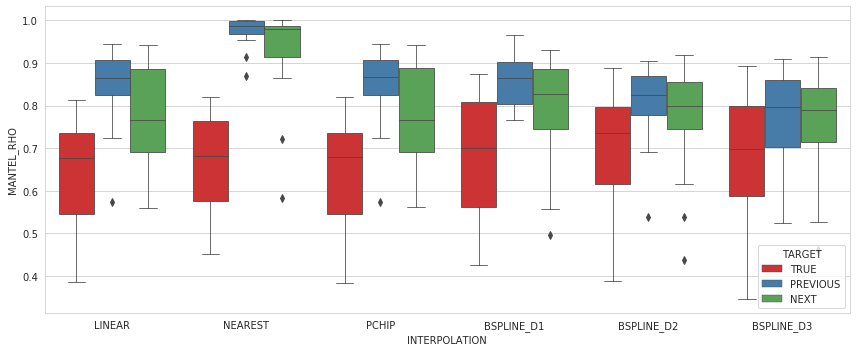

In [39]:
plot_boxplots(MANTEL_DF, 'MANTEL_RHO', 'mantel')

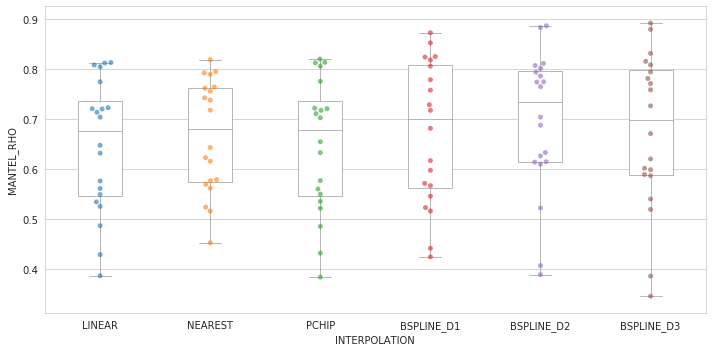

In [64]:
plot_true(MANTEL_DF, 'MANTEL_RHO', 'mantel')

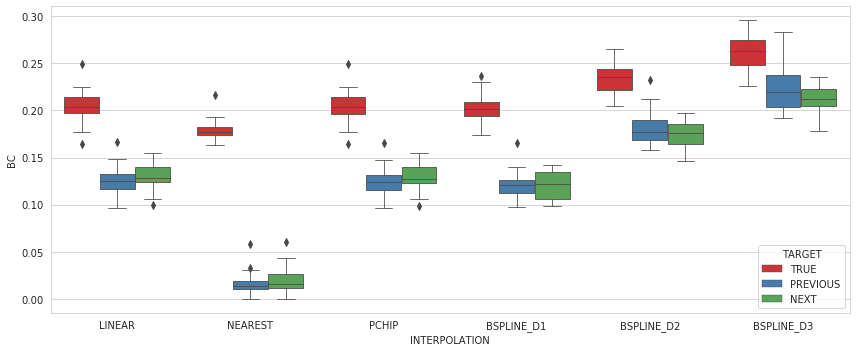

In [40]:
plot_boxplots(BC_DF, 'BC', 'bc')

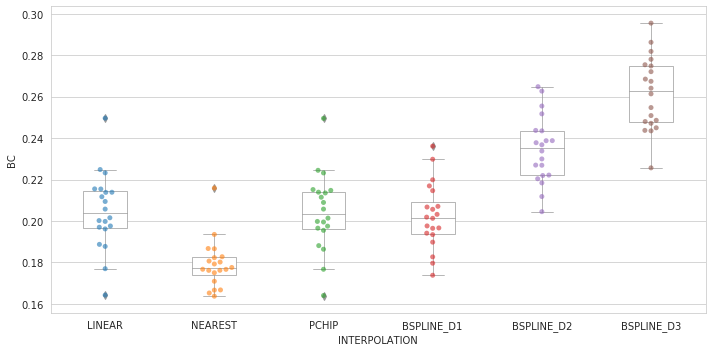

In [65]:
plot_true(BC_DF, 'BC', 'bc')

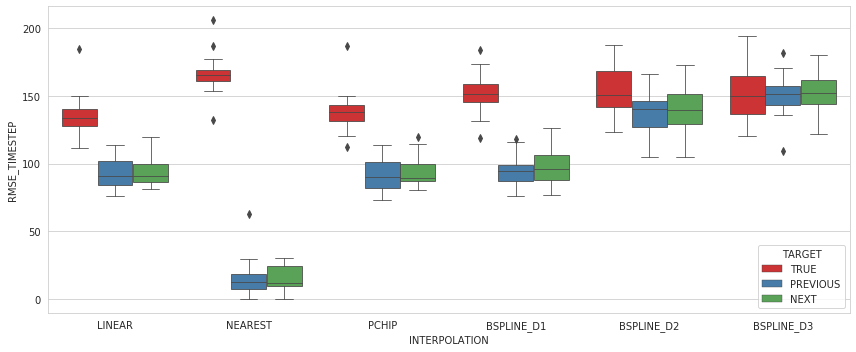

In [41]:
plot_boxplots(RMSE_TIME_DF, 'RMSE_TIMESTEP', 'rmse-timestep')

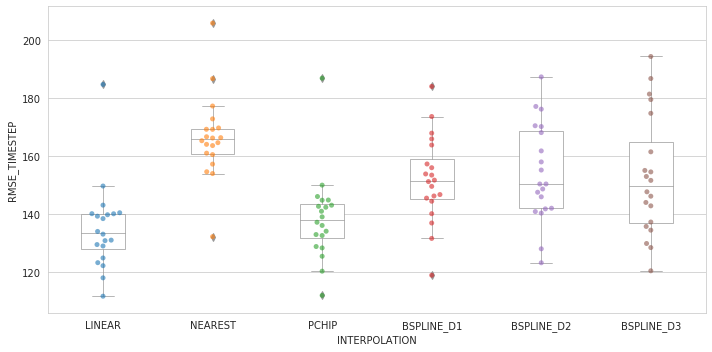

In [66]:
plot_true(RMSE_TIME_DF, 'RMSE_TIMESTEP', 'rmse-timestep')

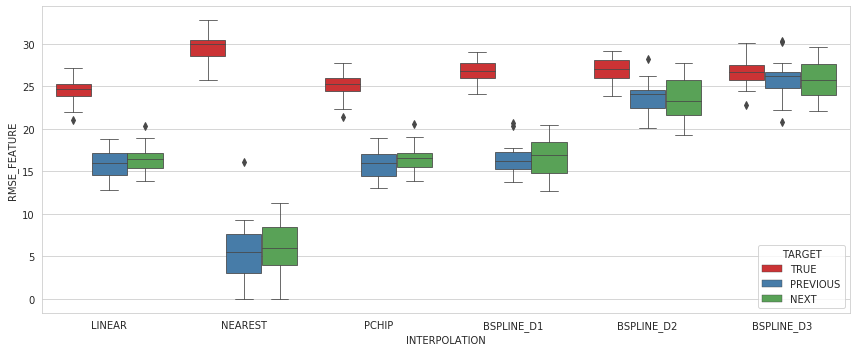

In [42]:
plot_boxplots(RMSE_FEAT_DF, 'RMSE_FEATURE', 'rmse-feature')

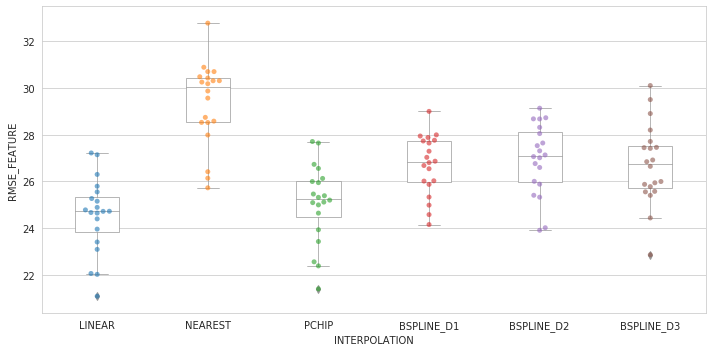

In [67]:
plot_true(RMSE_FEAT_DF, 'RMSE_FEATURE', 'rmse-feature')